In [1]:
import os

from google.colab import drive
drive.mount('/content/drive/')

## set a folder as current working dir

os.chdir('/content/drive/My Drive/AI4T/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
#df_raw =pd.read_csv('googleMap/BindaBasiniTemple_Google-Maps-Reviews-Scraper_2025-12-13_07-11-00-943.csv')
df_data=pd.read_csv('googleMap/Bindhyabasini_Temple_GoogleReviews.csv')

In [3]:
df_data.head()

,publishedAtDate,stars,text,reviewContext/Visited on,reviewContext/Wait time,likesCount
0,2025-12-13 06:46:09.023000+00:00,5,NaN,Weekend,No wait,0
1,2025-12-12 19:08:29.802000+00:00,5,Shree Bindhyabasini Temple is more than just o...,Weekday,No wait,0
2,2025-12-11 07:01:23.809000+00:00,5,Our visit to Shree Bindhyabasini Temple in Pok...,Weekday,No wait,0
3,2025-12-10 06:03:17.923000+00:00,5,NaN,Weekday,No wait,0
4,2025-12-09 20:43:32.644000+00:00,1,NaN,NaN,NaN,0


In [4]:
list(df_data.columns)


['publishedAtDate',
 'stars',
 'text',
 'reviewContext/Visited on',
 'reviewContext/Wait time',
 'likesCount']

# Data details
- The raw data is a flattened POI–review dataset that includes place metadata, user reviews, reviewer details, images, and scraping fields, and not all fields are useful, so it must be filtered and normalized based on analysis or application needs.

- We need to separate the data to match different analytical needs and data granularity:
  - df_analysis (Review-level) keeps review-level details required for text analytics, sentiment, seasonality, and visitor behavior studies, while avoiding redundant place information.
  - df_app (POI-level) aggregates data at the POI level, making it lightweight and efficient for maps, dashboards, ranking, and recommendation systems where only summarized place information is needed.

# Analysis Dataset

Purpose: NLP, sentiment analysis, temporal & visitor-behavior analysis
Granularity: 1 row = 1 review

Fields included

Review text

Rating / score

Review date

Visitor context (visitedIn, visit time, wait time, etc.)

In [5]:
df_data['reviewContext/Wait time'].nunique(),df_data[ 'reviewContext/Visited on'].nunique()

(5, 3)

In [6]:
df_data[ 'reviewContext/Visited on'].unique()

array(['Weekend', 'Weekday', nan, 'Public holiday'], dtype=object)

In [7]:
df_data.stars.nunique(), df_data.stars.unique(),

(5, array([5, 1, 4, 3, 2]))

In [8]:
df_data.publishedAtDate.nunique()

8314

In [9]:
df_data.text.nunique()

2776

In [10]:
df_data.likesCount.nunique()

13

In [11]:
df_data.columns

Index(['publishedAtDate', 'stars', 'text', 'reviewContext/Visited on',
       'reviewContext/Wait time', 'likesCount'],
      dtype='object')

In [12]:
df_data.describe()

,stars,likesCount
count,8314.000000,8314.000000
mean,4.585518,0.062665
std,0.784618,0.600368
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,35.000000


# EDA

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style for consistent visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


def initial_data_overview(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - The reviews DataFrame with selected columns
    Output: None (prints basic information and summaries)
    Task: Display shape, data types, summary statistics, missing values,
          and a few sample rows.
    """
    print("=== Dataset Shape ===")
    display(df.shape)
    print("\n=== Column Info ===")
    display(df.info())
    print("\n=== Summary Statistics ===")
    display(df.describe(include='all'))
    print("\n=== Missing Values ===")
    display(df.isnull().sum().sort_values(ascending=False))
    print("\n=== Sample 5 Random Rows ===")
    display(df.sample(5))


def plot_rating_distribution(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must contain 'stars' column
    Output: None (displays histogram and bar plot)
    Task: Visualize the distribution and proportion of star ratings.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x='stars', order=sorted(df['stars'].unique()))
    plt.title('Count of Each Star Rating')
    plt.xlabel('Stars')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    df['stars'].value_counts(normalize=True).sort_index().plot(kind='bar')
    plt.title('Proportion of Each Star Rating')
    plt.xlabel('Stars')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()

    print("Star Rating Proportions:")
    print(df['stars'].value_counts(normalize=True).sort_index().round(3))


def plot_reviews_over_time(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must have 'publishedAtDate' column (string with timezone)
    Output: None (displays time series plot)
    Task: Show monthly count of reviews and average star rating over time.
    Fixed to handle ISO8601 strings with/without fractional seconds and timezone.
    """
    df_time = df.copy()
    # Robust conversion for mixed ISO8601 formats with timezone
    df_time['publishedAtDate'] = pd.to_datetime(df_time['publishedAtDate'], utc=True, errors='coerce')

    if df_time['publishedAtDate'].isnull().any():
        print("Warning: Some dates could not be parsed.")

    df_time['year_month'] = df_time['publishedAtDate'].dt.to_period('M')

    monthly = df_time.groupby('year_month').agg(
        review_count=('stars', 'count'),
        avg_stars=('stars', 'mean')
    ).reset_index()
    monthly['year_month'] = monthly['year_month'].dt.to_timestamp()

    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(monthly['year_month'], monthly['review_count'], marker='o', color='tab:blue', label='Number of Reviews')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Reviews', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(monthly['year_month'], monthly['avg_stars'], marker='s', color='tab:orange', label='Average Stars')
    ax2.set_ylabel('Average Stars', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title('Reviews and Average Rating Over Time (Monthly)')
    fig.tight_layout()
    plt.show()

def analyze_review_text_length(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must contain 'text' column.
               'text_length' and 'word_count' will be computed if not present.
    Output: None (displays distributions and word cloud)
    Task: Compute (if needed) and visualize character/word count distributions,
          and generate a word cloud from review text.
    """
    df_local = df.copy()  # Avoid modifying original

    # Compute text_length and word_count if missing
    if 'text_length' not in df_local.columns:
        df_local['text_length'] = df_local['text'].astype(str).str.len()
        print("Computed 'text_length' column.")

    if 'word_count' not in df_local.columns:
        df_local['word_count'] = df_local['text'].astype(str).str.split().str.len()
        print("Computed 'word_count' column.")

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_local['text_length'].dropna(), bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Review Length (Characters)')
    plt.xlabel('Character Count')

    plt.subplot(1, 2, 2)
    sns.histplot(df_local['word_count'].dropna(), bins=50, kde=True, color='salmon')
    plt.title('Distribution of Review Word Count')
    plt.xlabel('Word Count')

    plt.tight_layout()
    plt.show()

    # Word Cloud
    text_all = " ".join(df_local['text'].dropna().astype(str))
    if len(text_all.strip()) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_all)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of All Reviews')
        plt.show()
    else:
        print("No review text available for word cloud.")


def analyze_context_features(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must contain 'reviewContext/Visited on' and 'reviewContext/Wait time'
    Output: None (displays count plots)
    Task: Visualize distribution of visit period and wait time categories.
    """
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    if 'reviewContext/Visited on' in df.columns and df['reviewContext/Visited on'].notna().any():
        visit_order = df['reviewContext/Visited on'].value_counts().index[:10]
        sns.countplot(data=df, y='reviewContext/Visited on', order=visit_order)
        plt.title('Top 10 Visit Periods')
    else:
        plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center')
        plt.title('Visited on Distribution')

    plt.subplot(1, 2, 2)
    if 'reviewContext/Wait time' in df.columns and df['reviewContext/Wait time'].notna().any():
        wait_order = df['reviewContext/Wait time'].value_counts().index
        sns.countplot(data=df, y='reviewContext/Wait time', order=wait_order)
        plt.title('Wait Time Distribution')
    else:
        plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center')
        plt.title('Wait Time Distribution')

    plt.tight_layout()
    plt.show()


def rating_vs_context_and_length_OLD(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must contain 'stars', 'text_length', 'word_count',
                               and optionally context columns
    Output: None (displays comparative plots)
    Task: Explore how star ratings vary with wait time, visit period, and review length.
    Fixed: Added explicit order for x='stars' to prevent seaborn from misinterpreting
          non-existent variables or defaulting incorrectly.
    """
    # Get unique stars in sorted order for consistent x-axis
    stars_order = sorted(df['stars'].dropna().unique())

    plt.figure(figsize=(16, 10))

    # Stars vs Wait Time
    plt.subplot(2, 2, 1)
    if 'reviewContext/Wait time' in df.columns and df['reviewContext/Wait time'].notna().any():
        sns.boxplot(data=df, x='stars', y='reviewContext/Wait time', order=stars_order)
        plt.title('Star Rating by Wait Time')
        plt.xlabel('Stars')
    else:
        plt.text(0.5, 0.5, 'No Wait time data', horizontalalignment='center', verticalalignment='center')
        plt.title('Star Rating by Wait Time')

    # Stars vs Visited on (top categories only)
    plt.subplot(2, 2, 2)
    if 'reviewContext/Visited on' in df.columns and df['reviewContext/Visited on'].notna().any():
        top_visits = df['reviewContext/Visited on'].value_counts().head(8).index
        df_top = df[df['reviewContext/Visited on'].isin(top_visits)]
        sns.violinplot(data=df_top, x='stars', y='reviewContext/Visited on', order=stars_order)
        plt.title('Star Rating by Visit Period (Top 8)')
        plt.xlabel('Stars')
    else:
        plt.text(0.5, 0.5, 'No Visited on data', horizontalalignment='center', verticalalignment='center')
        plt.title('Star Rating by Visit Period')

    # Stars vs Text Length
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df, x='stars', y='text_length', order=stars_order)
    plt.title('Review Length by Star Rating')
    plt.xlabel('Stars')
    plt.ylabel('Text Length (Characters)')

    # Stars vs Word Count
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='stars', y='word_count', order=stars_order)
    plt.title('Word Count by Star Rating')
    plt.xlabel('Stars')
    plt.ylabel('Word Count')

    plt.tight_layout()
    plt.show()



def plot_stars_vs_features(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must contain 'stars' column
    Output: None (displays up to 4 subplots with available data)
    Task: Plot relationships between stars and features safely.
    Final robust version:
      - Wait Time: Uses countplot (most appropriate for categorical wait time)
      - Visit Period: Violinplot (if enough data)
      - Text Length & Word Count: Boxplot with stars as numeric x-axis
    """
    plt.figure(figsize=(16, 10))
    subplot_idx = 1

    # 1. Wait Time vs Stars – Best as countplot (how many reviews per wait time, colored by stars)
    if 'reviewContext/Wait time' in df.columns:
        data_wait = df.dropna(subset=['reviewContext/Wait time'])
        if not data_wait.empty:
            plt.subplot(2, 2, subplot_idx)
            order_wait = data_wait['reviewContext/Wait time'].value_counts().index
            sns.countplot(data=data_wait, y='reviewContext/Wait time', hue='stars', order=order_wait, palette="viridis")
            plt.title('Distribution of Wait Time Categories by Stars')
            plt.xlabel('Number of Reviews')
            plt.legend(title='Stars', bbox_to_anchor=(1.05, 1), loc='upper left')
            subplot_idx += 1

    # 2. Visit Period vs Stars
    if 'reviewContext/Visited on' in df.columns:
        data_visit = df.dropna(subset=['reviewContext/Visited on'])
        if not data_visit.empty and len(data_visit) > 10:  # Need some minimum data
            top_visits = data_visit['reviewContext/Visited on'].value_counts().head(8).index
            df_top = data_visit[data_visit['reviewContext/Visited on'].isin(top_visits)]
            plt.subplot(2, 2, subplot_idx)
            sns.violinplot(data=df_top, x='stars', y='reviewContext/Visited on', palette="Set2")
            plt.title('Stars by Visit Period (Top 8)')
            plt.xlabel('Stars')
            subplot_idx += 1

    # 3. Text Length by Stars
    df_local = df.copy()
    if 'text' in df_local.columns:
        if 'text_length' not in df_local.columns:
            df_local['text_length'] = df_local['text'].astype(str).str.len()
        if 'word_count' not in df_local.columns:
            df_local['word_count'] = df_local['text'].astype(str).str.split().str.len()

    if 'text_length' in df_local.columns:
        data_len = df_local.dropna(subset=['stars', 'text_length'])
        if not data_len.empty:
            plt.subplot(2, 2, subplot_idx)
            sns.boxplot(data=data_len, x='stars', y='text_length', palette="Set3")
            plt.title('Review Text Length by Stars')
            plt.xlabel('Stars')
            plt.ylabel('Text Length (characters)')
            subplot_idx += 1

    # 4. Word Count by Stars
    if 'word_count' in df_local.columns:
        data_word = df_local.dropna(subset=['stars', 'word_count'])
        if not data_word.empty:
            plt.subplot(2, 2, subplot_idx)
            sns.boxplot(data=data_word, x='stars', y='word_count', palette="Set3")
            plt.title('Review Word Count by Stars')
            plt.xlabel('Stars')
            plt.ylabel('Word Count')
            subplot_idx += 1

    if subplot_idx == 1:
        plt.text(0.4, 0.5, 'No features available to plot',
                 ha='center', va='center', fontsize=16, transform=plt.gcf().transFigure)
    else:
        plt.suptitle('Star Ratings vs Review Features', fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()



def analyze_likes_distribution(df: pd.DataFrame) -> None:
    """
    Input: df (pd.DataFrame) - Must contain 'likesCount' column
    Output: None (displays distributions and prints top liked reviews)
    Task: Visualize the distribution of likesCount and show the most helpful (most liked) reviews.
    Fixed: No longer assumes 'text_length' exists in the DataFrame.
           Computes it only when needed for display, and gracefully handles missing columns.
    """
    if 'likesCount' not in df.columns:
        print("Error: 'likesCount' column is missing in the DataFrame.")
        return

    plt.figure(figsize=(14, 5))

    # Main distribution (all likes, including zeros)
    plt.subplot(1, 2, 1)
    sns.histplot(df['likesCount'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Likes Count (All Reviews)')
    plt.xlabel('Number of Likes')
    plt.ylabel('Count')

    # Non-zero likes on log scale
    plt.subplot(1, 2, 2)
    non_zero_likes = df[df['likesCount'] > 0]['likesCount']
    if not non_zero_likes.empty:
        sns.histplot(non_zero_likes, bins=50, kde=True, color='salmon')
        plt.xscale('log')
        plt.title('Likes Distribution (Non-Zero, Log Scale)')
        plt.xlabel('Number of Likes (log scale)')
    else:
        plt.text(0.5, 0.5, 'No reviews with likes > 0', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Likes Distribution (Non-Zero)')

    plt.tight_layout()
    plt.show()

    # Top 10 most liked reviews
    print("Top 10 Most Liked Reviews:")
    top_liked = df.nlargest(10, 'likesCount')

    # Select only columns that actually exist
    available_cols = ['stars', 'text', 'likesCount']
    if 'text_length' in df.columns:
        available_cols.append('text_length')
    if 'word_count' in df.columns:
        available_cols.append('word_count')

    display_cols = [col for col in available_cols if col in top_liked.columns]

    if 'text' in display_cols:
        # Show truncated text for readability
        display_df = top_liked[display_cols].copy()
        display_df['text'] = display_df['text'].astype(str).str[:200] + ['...' if len(t) > 200 else '' for t in display_df['text']]
    else:
        display_df = top_liked[display_cols]

    print(display_df.to_string(index=False))



In [14]:
initial_data_overview(df_data)

=== Dataset Shape ===


(8314, 6)


=== Column Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8314 entries, 0 to 8313
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   publishedAtDate           8314 non-null   object
 1   stars                     8314 non-null   int64 
 2   text                      3302 non-null   object
 3   reviewContext/Visited on  1129 non-null   object
 4   reviewContext/Wait time   1179 non-null   object
 5   likesCount                8314 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 389.8+ KB


None


=== Summary Statistics ===


,publishedAtDate,stars,text,reviewContext/Visited on,reviewContext/Wait time,likesCount
count,8314,8314.000000,3302,1129,1179,8314.000000
unique,8314,NaN,2776,3,5,NaN
top,2018-03-31 07:51:18.799000+00:00,NaN,Good,Weekday,No wait,NaN
freq,1,NaN,63,674,826,NaN
mean,NaN,4.585518,NaN,NaN,NaN,0.062665
std,NaN,0.784618,NaN,NaN,NaN,0.600368
min,NaN,1.000000,NaN,NaN,NaN,0.000000
25%,NaN,4.000000,NaN,NaN,NaN,0.000000
50%,NaN,5.000000,NaN,NaN,NaN,0.000000
75%,NaN,5.000000,NaN,NaN,NaN,0.000000



=== Missing Values ===


,0
reviewContext/Visited on,7185
reviewContext/Wait time,7135
text,5012
publishedAtDate,0
stars,0
likesCount,0



=== Sample 5 Random Rows ===


,publishedAtDate,stars,text,reviewContext/Visited on,reviewContext/Wait time,likesCount
6533,2019-09-29 07:31:36.588000+00:00,3,NaN,NaN,NaN,0
6061,2019-12-10 10:44:56.630000+00:00,5,NaN,NaN,NaN,0
456,2025-05-14 16:15:48.750000+00:00,5,NaN,Weekend,No wait,0
7223,2019-06-13 10:04:42.876000+00:00,5,NaN,NaN,NaN,0
7232,2019-06-12 02:04:44.485000+00:00,5,NaN,NaN,NaN,0


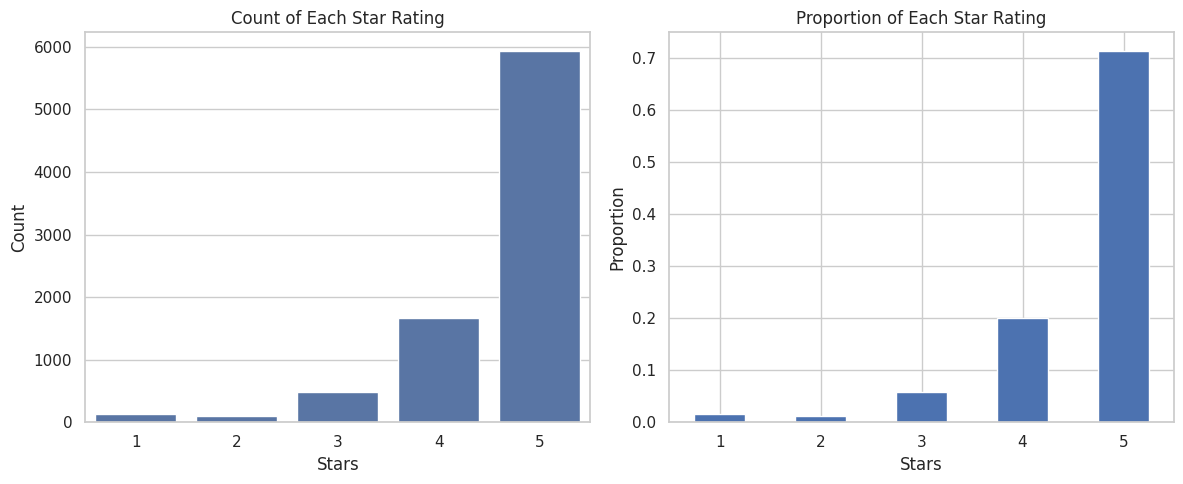

Star Rating Proportions:
stars
1    0.016
2    0.011
3    0.059
4    0.201
5    0.714
Name: proportion, dtype: float64


In [15]:
plot_rating_distribution(df_data)

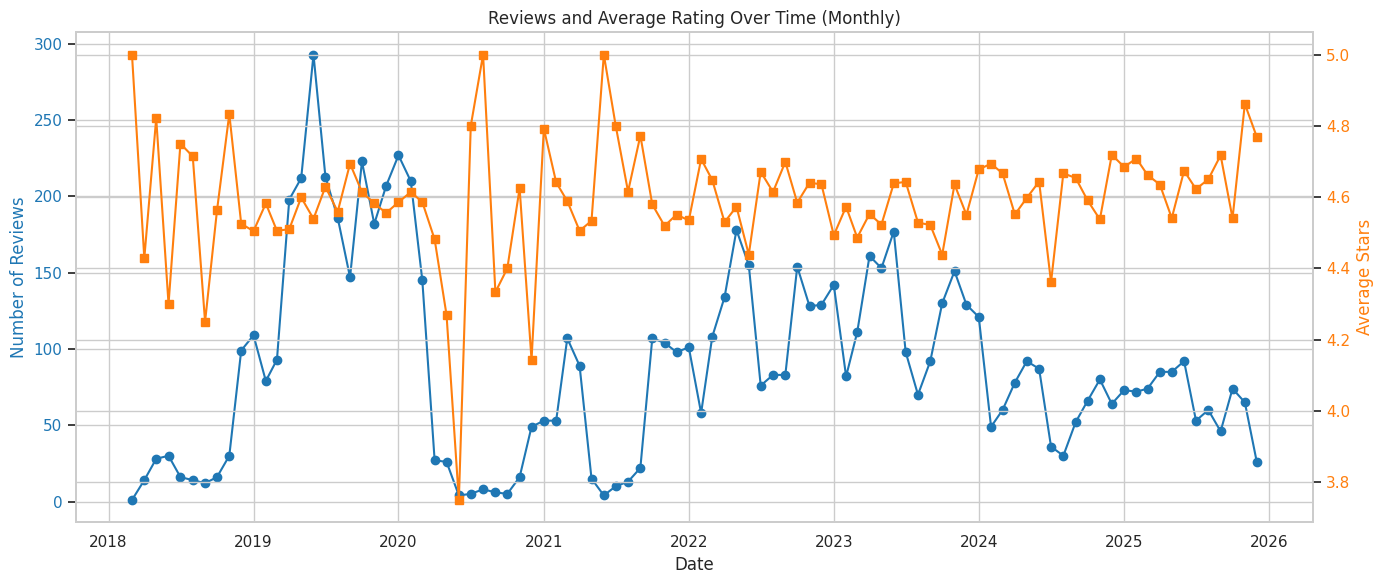

In [16]:
plot_reviews_over_time(df_data)

Computed 'text_length' column.
Computed 'word_count' column.


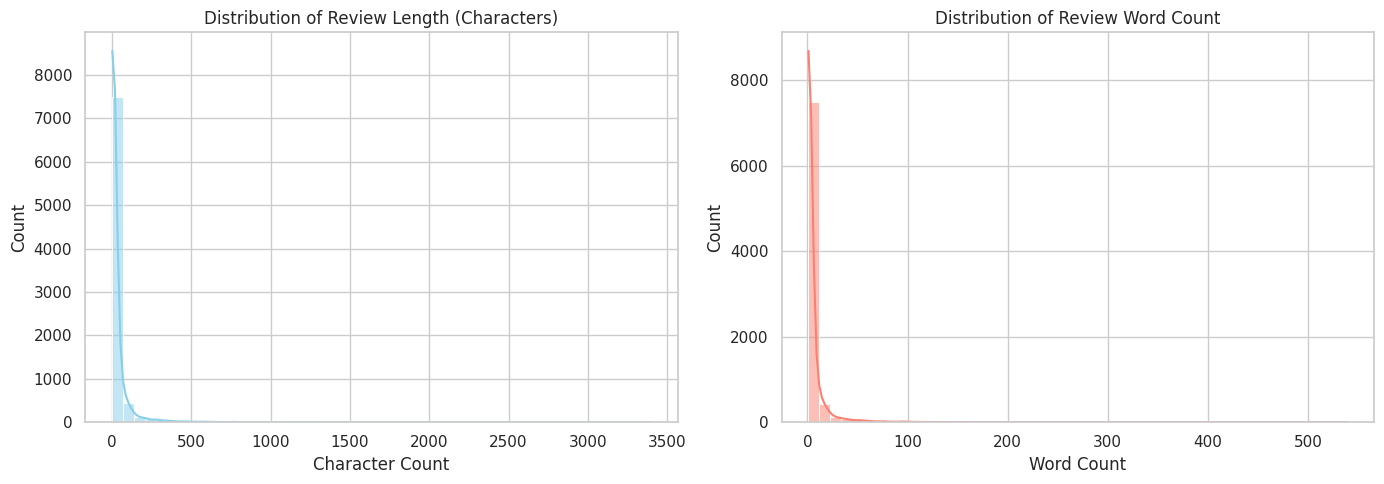

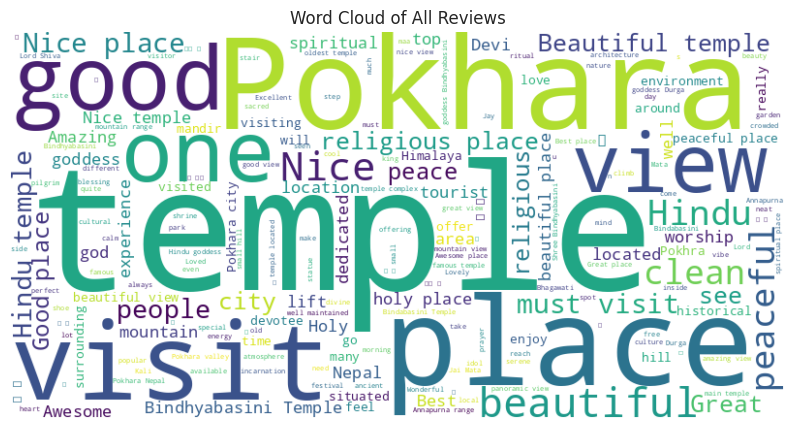

In [17]:



analyze_review_text_length(df_data)

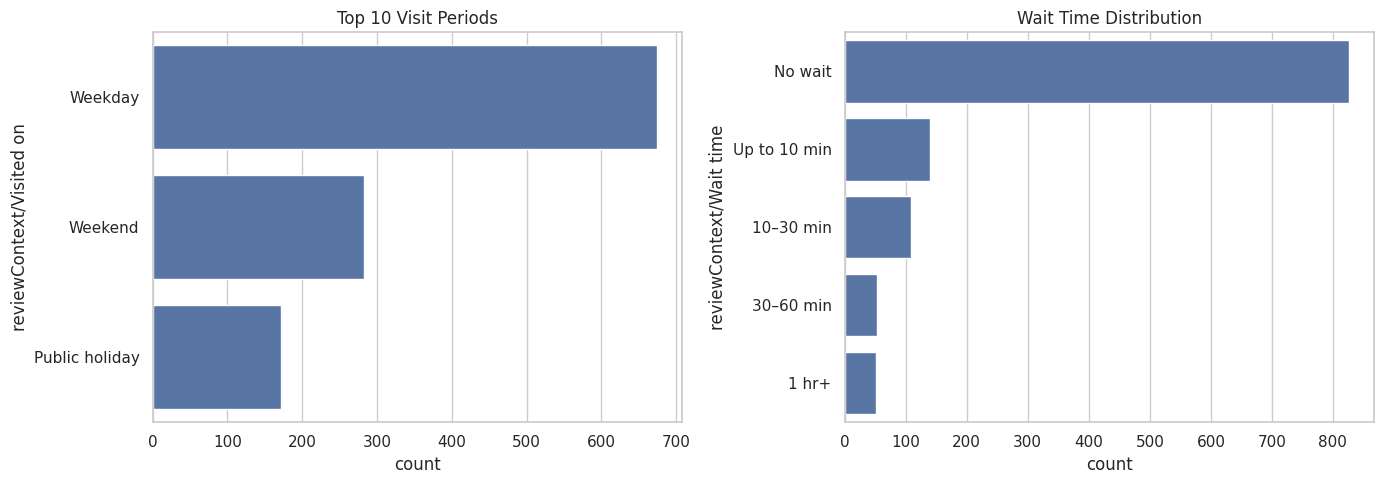

In [18]:

analyze_context_features(df_data)

Overall unique stars: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Null counts in context columns:
reviewContext/Wait time     7135
reviewContext/Visited on    7185
dtype: int64

Value counts for Wait time:
reviewContext/Wait time
NaN             7135
No wait          826
Up to 10 min     140
10–30 min        108
30–60 min         53
1 hr+             52
Name: count, dtype: int64


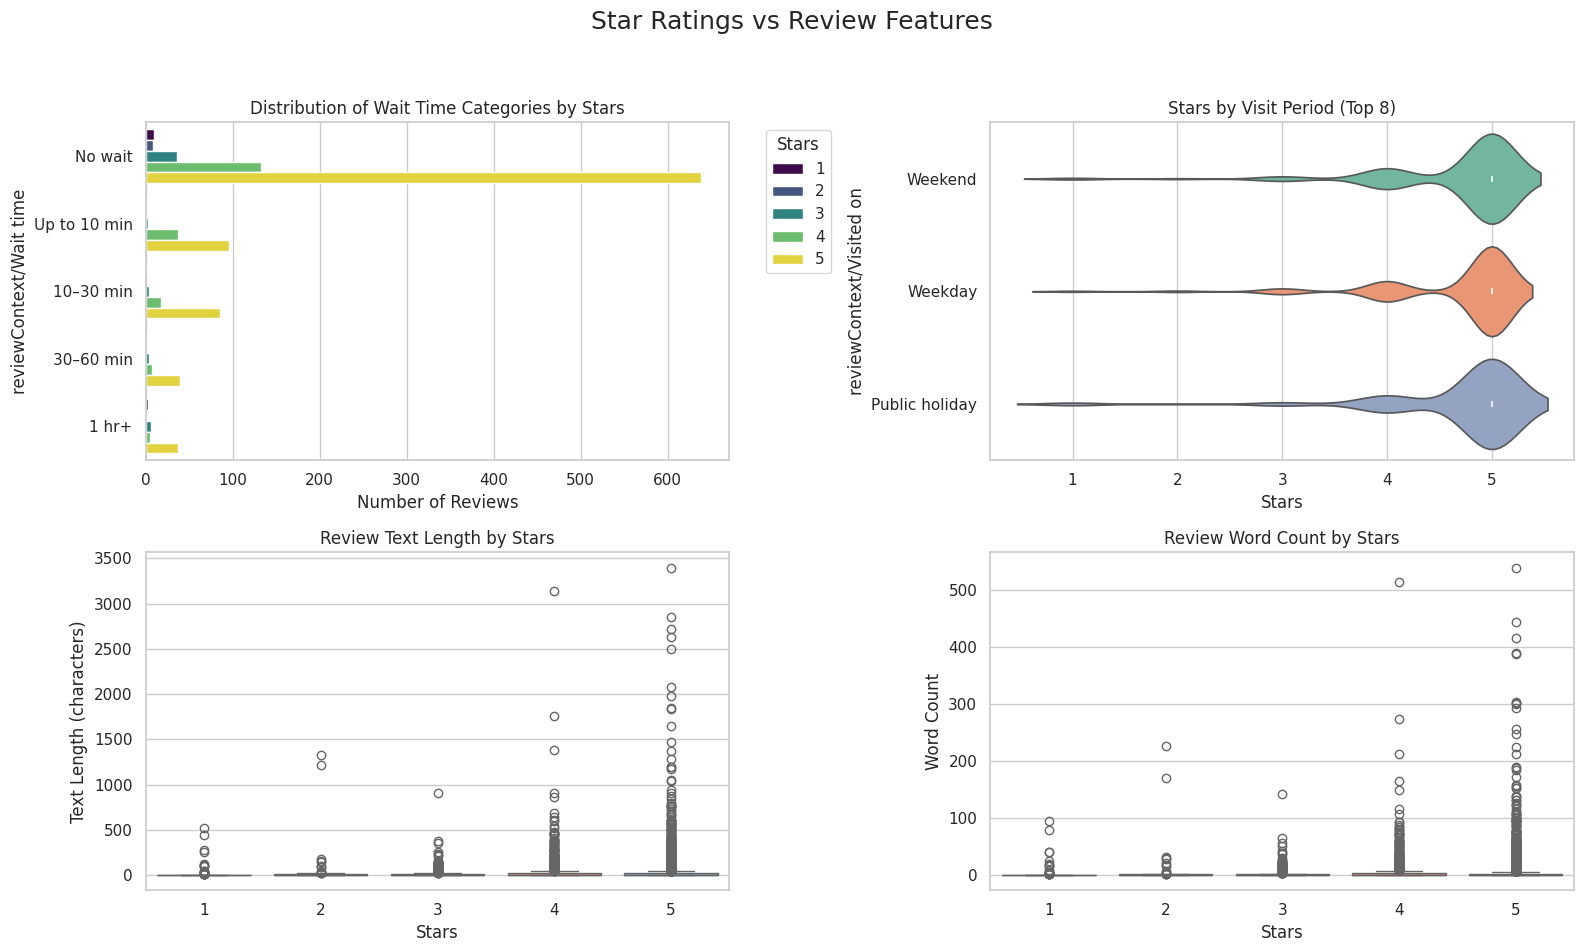

In [19]:



print("Overall unique stars:", sorted(df_data['stars'].dropna().unique()))
print("\nNull counts in context columns:")
print(df_data[['reviewContext/Wait time', 'reviewContext/Visited on']].isnull().sum())
print("\nValue counts for Wait time:")
print(df_data['reviewContext/Wait time'].value_counts(dropna=False))
plot_stars_vs_features(df_data)

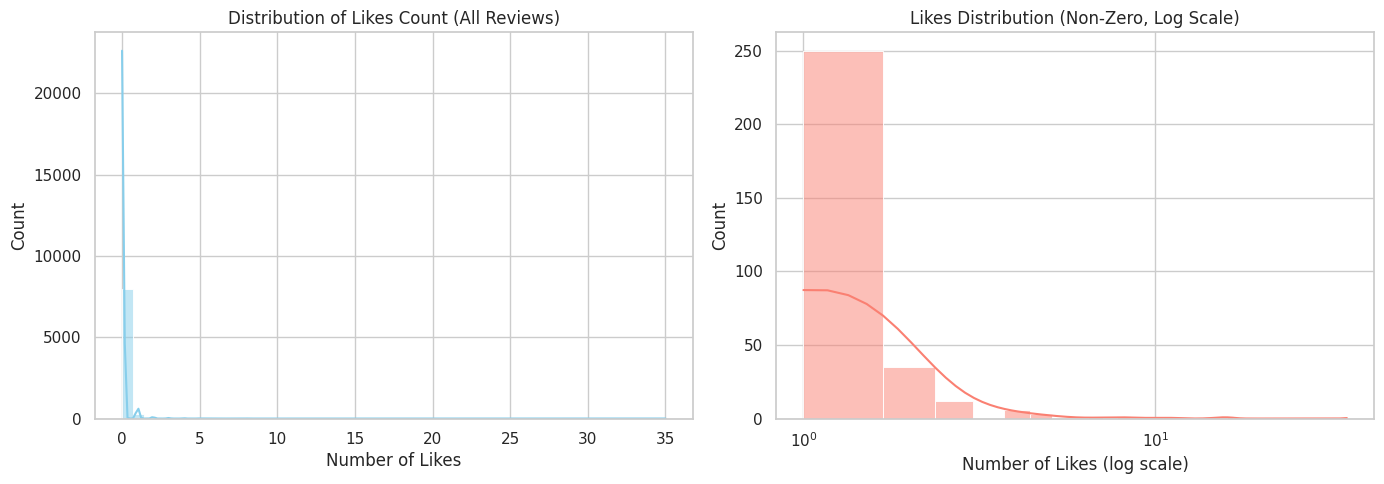

Top 10 Most Liked Reviews:
 stars                                                                                                                                                                                                        text  likesCount
     5                                                                                                         It's a beautiful temple...\nPeople worships MAA Bindhyabasini here...\nSIVA Temple also nearby it..          35
     5 Bindhyabasini temple is of great religious importance to Hindus living in the Pokhara region. The temple itself is dedicated to the Hindu goddess Durga, who is Pokhara's chosen guardian deity. You can...          16
     5 I visit this temple every time I go to Pokhara. It is major tourist attraction and a popular destination for natives. It offers a lift charging a small fee for those devotees who cannot walk or are di...          16
     5 The change here is great but the Architecture that it is starting to take 

In [20]:

analyze_likes_distribution(df_data)